In [1]:
#Load in packages
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import contextily as cx
import warnings
import geoplot as gplt
import geoplot.crs as gcrs
from numpy import log10
import os
from shapely.geometry.point import Point
import matplotlib.cbook as cbook
from matplotlib.gridspec import GridSpec
import plotly.express as px

In [2]:
#Allow full display of columns in data
pd.set_option("display.max_columns", 100,"display.max_rows",100)

In [3]:
#Read in Durham Police Department call data
dpdcalls = gpd.read_file('/Users/sadiesheridan/Desktop/dpdshapefile/dpdshapefile.shp')
dpdcalls.set_crs('epsg:4326')
dpdcalls.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
#Determine which call types to keep with nature_list
nature_list = ('PANHANDLING OR NUISANCE', 'SUICIDE THREAT', 'INTOXICATED PERSON', 'MENTAL DISORDER', 'WELFARE CHECK', 'URGENT WELFARE CHECK', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR UNWANTED', 'DISTURBANCE')

#Determine which priority levels to use for priority_list
priority_list = ['2', '3', '4', '5', '6']

#Determine which beats are in Durham
policebeats_list_obj = ['121', '122', '112', '111', '123', '114', '113', '124', '212', '214', '213', '211', '223', '222', '221', '224', '313', '312', '321', '314', '323', '324', '322', '311', '411', '415', '412', '413', '414', '422', '421', '423', '511', '512', '513']

In [5]:
#Filter out cancelled calls and self initiated calls
dpdcalls = dpdcalls.loc[dpdcalls["Source"] != "Self Initiated"].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Cancelled"] == 0].copy()
dpdcalls = dpdcalls.loc[(dpdcalls["Beat"] != "DSO") & (dpdcalls["Beat"] != "SSA")].copy()

#Filter out for hang ups and unreadable natures (in the case that the call types in nature_list aren't specified)
# dpdcalls = dpdcalls.loc[dpdcalls["Nature"] != "HANG UP"].copy()
# dpdcalls = dpdcalls.loc[(dpdcalls["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls["Nature"] != "0") & (dpdcalls["Nature"] != "16") & (dpdcalls["Nature"] != "DIRECTED PATROL") & (dpdcalls["Nature"] != "NO apt # or phone") & (dpdcalls["Nature"] != "\\") & (dpdcalls["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls["Nature"] != "DISy") & (dpdcalls["Nature"] != "VEr") & (dpdcalls["Nature"] != "DIST") & (dpdcalls['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()

#Filter out for only calls in nature_list
dpdcalls = dpdcalls[dpdcalls['Nature'].isin(nature_list)].copy()

#Filter out for only priority levels in priority_list
dpdcalls = dpdcalls[dpdcalls['Priority'].isin(priority_list)].copy()

#Filter out for only calls within Durham Police Beats
dpdcalls = dpdcalls.loc[dpdcalls['Beat'].isin(policebeats_list_obj)].copy()

#Filter out null x and y values
dpdcalls = dpdcalls.loc[(dpdcalls["X"] != 0) & (dpdcalls["Y"] != 0)].copy()

dpdcalls.head()

Event Numb Case Numbe Call Date   Call Time             Source Priority  \
72    21000110       None  1/1/2021  12:40:00AM         Phone Call        2   
74    21000113       None  1/1/2021  12:41:03AM  Wireless 911 Call        2   
75    21000114       None  1/1/2021  12:41:53AM  Wireless 911 Call        3   
78    21000119       None  1/1/2021  12:44:24AM              E-911        3   
84    21000130       None  1/1/2021  12:49:53AM  Wireless 911 Call        2   

                  Nature                  Address        X       Y District  \
72           DISTURBANCE        3600 N ROXBORO ST  2029653  832422       D2   
74  TRESPASS OR UNWANTED            2300 GUESS RD  2022916  828272       D2   
75                CRISIS               0 HAYTI LN  2030397  813534       D4   
78         WELFARE CHECK            500 E MAIN ST  2031074  816191       D5   
84           DISTURBANCE  5100 OLD CHAPEL HILL RD  2003518  799213       D3   

   Beat               Dispositio  Cancelled                    geometry  
72  213  Resolved Without Report          0  POINT (-78.89970 36.03711)  
74  211  Resolved Without Report          0  POINT (-78.92250 36.02572)  
75  411  Resolved Without Report          0  POINT (-78.89725 35.98522)  
78  513  Resolved Without Report          0  POINT (-78.89496 35.99252)  
84  323  Resolved Without Report          0  POINT (-78.98811 35.94592)

In [6]:
#Create lists for specific beat groups
group1_list = [112, 113, 214, 223, 411, 511, 512, 513]
group2_list = [122, 222, 111, 213]
commsafe_list = [112, 113, 214, 223, 411, 511, 512, 513, 122, 222, 111, 213]

In [7]:
#Create the same lists to use when Beat is in object form
group1_list_obj = ['112', '113', '214', '223', '411', '511', '512', '513']
group2_list_obj = ['122', '222', '111', '213']
commsafe_list_obj = ['112', '113', '214', '223', '411', '511', '512', '513', '122', '222', '111', '213']

In [8]:
#Find most common Nature of calls
csdnature = dpdcalls.groupby(['Nature']).size().to_frame(name = 'Durham Beats Call Count').reset_index()
csdnature.sort_values(by='Durham Beats Call Count', inplace=True, ascending=False)
csdnature.head(20)

Nature  Durham Beats Call Count
2              DISTURBANCE                     7919
7     TRESPASS OR UNWANTED                     4940
0            ASSIST PERSON                     3053
8     URGENT WELFARE CHECK                     1950
9            WELFARE CHECK                     1651
1                   CRISIS                     1323
5  PANHANDLING OR NUISANCE                      787
6           SUICIDE THREAT                      582
3       INTOXICATED PERSON                      440
4          MENTAL DISORDER                       19

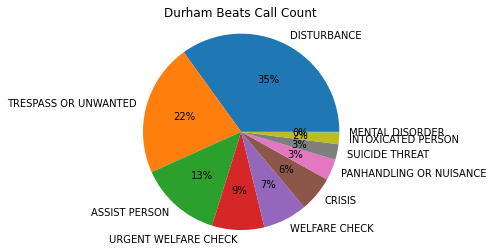

In [9]:
#Create a pie chart for the nature of calls
plt.pie(csdnature['Durham Beats Call Count'],autopct='%1.0f%%', labels=csdnature['Nature'])
plt.axis('equal')
plt.title('Durham Beats Call Count')
plt.show()

In [10]:
#Find the most common Nature of comsafe call types for just comsafe beats
csdnature_commsafe = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()
csdnature_commsafe = csdnature_commsafe.groupby(['Nature']).size().to_frame(name = 'Community Safety Beats Call Count').reset_index()
csdnature_commsafe.sort_values(by='Community Safety Beats Call Count', inplace=True, ascending=False)
csdnature_commsafe

Nature  Community Safety Beats Call Count
2              DISTURBANCE                               3049
7     TRESPASS OR UNWANTED                               2210
0            ASSIST PERSON                                975
8     URGENT WELFARE CHECK                                615
1                   CRISIS                                545
9            WELFARE CHECK                                520
5  PANHANDLING OR NUISANCE                                371
6           SUICIDE THREAT                                199
3       INTOXICATED PERSON                                188
4          MENTAL DISORDER                                 11

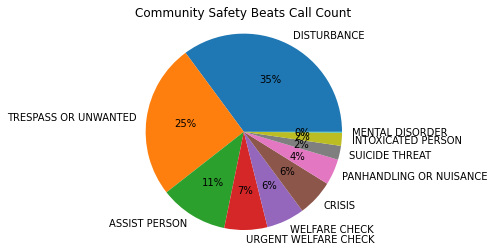

In [11]:
#Create a pie chart for the nature of calls for community safety beats
plt.pie(csdnature_commsafe['Community Safety Beats Call Count'], autopct='%1.0f%%', labels=csdnature['Nature'])
plt.axis('equal')
plt.title('Community Safety Beats Call Count')
plt.show()

In [12]:
#Find the most common Nature of comsafe call types for group 1 beats
csdnature_group1 = dpdcalls.loc[dpdcalls['Beat'].isin(group1_list_obj)].copy()
csdnature_group1 = csdnature_group1.groupby(['Nature']).size().to_frame(name = 'Group 1 Beats Call Count').reset_index()
csdnature_group1.sort_values(by='Group 1 Beats Call Count', inplace=True, ascending=False)
csdnature_group1

Nature  Group 1 Beats Call Count
2              DISTURBANCE                      1978
7     TRESPASS OR UNWANTED                      1605
0            ASSIST PERSON                       643
8     URGENT WELFARE CHECK                       400
1                   CRISIS                       392
9            WELFARE CHECK                       341
5  PANHANDLING OR NUISANCE                       269
6           SUICIDE THREAT                       153
3       INTOXICATED PERSON                       142
4          MENTAL DISORDER                         8

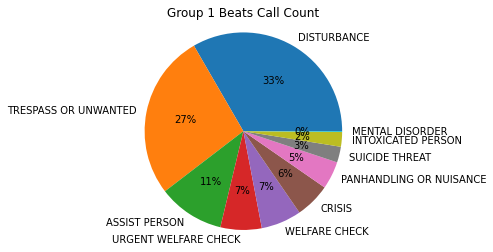

In [13]:
#Create a pie chart for the nature of calls for group 1 beats
plt.pie(csdnature_group1['Group 1 Beats Call Count'], autopct='%1.0f%%', labels=csdnature['Nature'])
plt.axis('equal')
plt.title('Group 1 Beats Call Count')
plt.show()

In [14]:
#Find the most common Nature of comsafe call types for group 2 beats
csdnature_group2 = dpdcalls.loc[dpdcalls['Beat'].isin(group2_list_obj)].copy()
csdnature_group2 = csdnature_group2.groupby(['Nature']).size().to_frame(name = 'Group 2 Beats Call Count').reset_index()
csdnature_group2.sort_values(by='Group 2 Beats Call Count', inplace=True, ascending=False)
csdnature_group2

Nature  Group 2 Beats Call Count
2              DISTURBANCE                      1071
7     TRESPASS OR UNWANTED                       605
0            ASSIST PERSON                       332
8     URGENT WELFARE CHECK                       215
9            WELFARE CHECK                       179
1                   CRISIS                       153
5  PANHANDLING OR NUISANCE                       102
3       INTOXICATED PERSON                        46
6           SUICIDE THREAT                        46
4          MENTAL DISORDER                         3

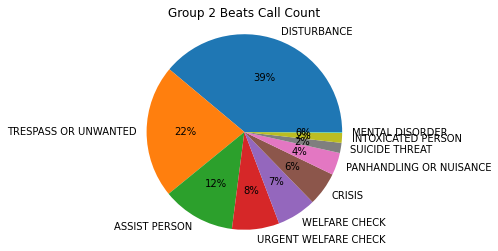

In [15]:
#Create a pie chart for the nature of calls for group 2 beats
plt.pie(csdnature_group2['Group 2 Beats Call Count'], autopct='%1.0f%%', labels=csdnature['Nature'])
plt.axis('equal')
plt.title('Group 2 Beats Call Count')
plt.show()

In [16]:
#Merge the csd nature tables together
csdnature_counts = pd.merge(csdnature_commsafe, csdnature, on='Nature')
csdnature_counts = csdnature_counts.set_index('Nature')
csdnature_counts

Community Safety Beats Call Count  \
Nature                                                       
DISTURBANCE                                           3049   
TRESPASS OR UNWANTED                                  2210   
ASSIST PERSON                                          975   
URGENT WELFARE CHECK                                   615   
CRISIS                                                 545   
WELFARE CHECK                                          520   
PANHANDLING OR NUISANCE                                371   
SUICIDE THREAT                                         199   
INTOXICATED PERSON                                     188   
MENTAL DISORDER                                         11   

                         Durham Beats Call Count  
Nature                                            
DISTURBANCE                                 7919  
TRESPASS OR UNWANTED                        4940  
ASSIST PERSON                               3053  
URGENT WELFARE CHECK                        1950  
CRISIS                                      1323  
WELFARE CHECK                               1651  
PANHANDLING OR NUISANCE                      787  
SUICIDE THREAT                               582  
INTOXICATED PERSON                           440  
MENTAL DISORDER                               19

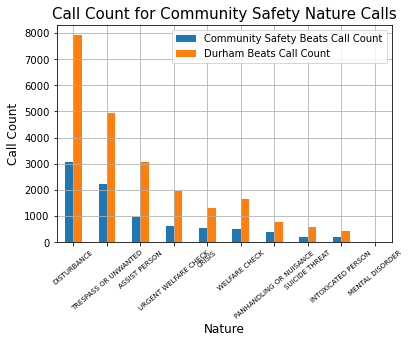

In [17]:
#Create a bar plot to compare nature count in durham and community safety beats
ax = csdnature_counts.plot.bar(grid=True)

plt.xticks(rotation=40, fontsize=7)
plt.title("Call Count for Community Safety Nature Calls", fontsize = 15)
plt.xlabel("Nature", fontsize=12)
plt.ylabel("Call Count", fontsize=12)
plt.show()

In [18]:
#Find the most common Nature of comsafe call types for just group 1 beats
csdnature_group1 = dpdcalls.loc[dpdcalls['Beat'].isin(group1_list_obj)].copy()
csdnature_group1 = csdnature_group1.groupby(['Nature']).size().to_frame(name = 'Group 1 Beats Call Count').reset_index()
csdnature_group1.sort_values(by='Group 1 Beats Call Count', inplace=True, ascending=False)
csdnature_group1

Nature  Group 1 Beats Call Count
2              DISTURBANCE                      1978
7     TRESPASS OR UNWANTED                      1605
0            ASSIST PERSON                       643
8     URGENT WELFARE CHECK                       400
1                   CRISIS                       392
9            WELFARE CHECK                       341
5  PANHANDLING OR NUISANCE                       269
6           SUICIDE THREAT                       153
3       INTOXICATED PERSON                       142
4          MENTAL DISORDER                         8

In [19]:
#Find the most common Nature of comsafe call types for just group 2 beats
csdnature_group2 = dpdcalls.loc[dpdcalls['Beat'].isin(group2_list_obj)].copy()
csdnature_group2 = csdnature_group2.groupby(['Nature']).size().to_frame(name = 'Group 2 Beats Call Count').reset_index()
csdnature_group2.sort_values(by='Group 2 Beats Call Count', inplace=True, ascending=False)
csdnature_group2

Nature  Group 2 Beats Call Count
2              DISTURBANCE                      1071
7     TRESPASS OR UNWANTED                       605
0            ASSIST PERSON                       332
8     URGENT WELFARE CHECK                       215
9            WELFARE CHECK                       179
1                   CRISIS                       153
5  PANHANDLING OR NUISANCE                       102
3       INTOXICATED PERSON                        46
6           SUICIDE THREAT                        46
4          MENTAL DISORDER                         3

In [20]:
#Merge the csd groups together
csdnature_counts_groups = pd.merge(csdnature_group1, csdnature_group2, on='Nature')
csdnature_counts_groups = csdnature_counts_groups.set_index('Nature')
csdnature_counts_groups

Group 1 Beats Call Count  Group 2 Beats Call Count
Nature                                                                     
DISTURBANCE                                  1978                      1071
TRESPASS OR UNWANTED                         1605                       605
ASSIST PERSON                                 643                       332
URGENT WELFARE CHECK                          400                       215
CRISIS                                        392                       153
WELFARE CHECK                                 341                       179
PANHANDLING OR NUISANCE                       269                       102
SUICIDE THREAT                                153                        46
INTOXICATED PERSON                            142                        46
MENTAL DISORDER                                 8                         3

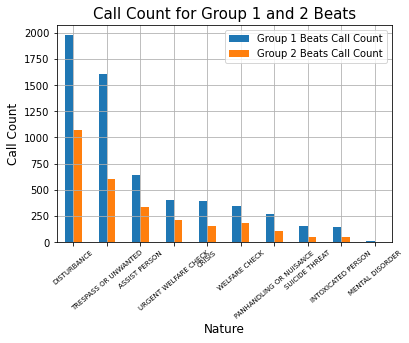

In [21]:
#Create a bar plot to compare nature count in group 1 and 2
ax = csdnature_counts_groups.plot.bar(grid=True)

plt.xticks(rotation=40, fontsize=7)
plt.title("Call Count for Group 1 and 2 Beats", fontsize = 15)
plt.xlabel("Nature", fontsize=12)
plt.ylabel("Call Count", fontsize=12)
plt.show()

In [22]:
#Find the most common Address of calls
calladdress = dpdcalls.groupby(['Address']).size().to_frame(name = 'Address Count').reset_index()
calladdress.sort_values(by='Address Count', inplace=True, ascending=False)
calladdress.head(10)

Address  Address Count
2333  3400 HILLSBOROUGH RD            341
536      1000 N MIAMI BLVD            238
1593     2100 N ROXBORO ST            199
3021        5000 NC 55 HWY            169
748         1200 E MAIN ST            165
3537       800 W CLUB BLVD            149
1587      2100 HOLLOWAY ST            138
1794         2500 GUESS RD            134
1903         2700 GUESS RD            134
2154      300 S LASALLE ST            131

In [23]:
#Find the most common address of calls for community safety beats
callsaddress_commsafe = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()
callsaddress_commsafe = callsaddress_commsafe.groupby(['Address']).size().to_frame(name = 'Address Count').reset_index()
callsaddress_commsafe['Address Count'] = callsaddress_commsafe['Address Count'].astype(str).astype(int)
callsaddress_commsafe.sort_values(by='Address Count', inplace=True, ascending=False)
callsaddress_commsafe.head(10)

Address  Address Count
141    1000 N MIAMI BLVD            238
496    2100 N ROXBORO ST            199
214       1200 E MAIN ST            165
493     2100 HOLLOWAY ST            138
478    2000 N ROXBORO ST            129
695    3600 N ROXBORO ST            121
1050  900 CHALK LEVEL RD             98
741       400 LIBERTY ST             97
821       4800 DANUBE LN             94
136    1000 N ALSTON AVE             94

In [24]:
#Read in policebeats data set
policebeats = gpd.read_file('/Users/sadiesheridan/Desktop/Police_Beats/Police_Beats.shp')
policebeats.set_crs('epsg:4326')
policebeats.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
#Filter out beats not in Durham for policebeats
policebeats_list = [121, 122, 112, 111, 123, 114, 113, 124, 212, 214, 213, 211, 223, 222, 221, 224, 313, 312, 321, 314, 323, 324, 322, 311, 411, 415, 412, 413, 414, 422, 421, 423, 511, 512, 513]
policebeats = policebeats.loc[policebeats["LAWBEAT"].isin(policebeats_list)].copy()
policebeats.head()

OBJECTID      PERIMETER STATUS CONTIGUOUS LAWDIST  LAWBEAT  CAD  \
11        12   94210.453125      I         no      D2      224  224   
12        13  116621.601562      I        yes      D2      224  224   
13        14   12884.019531      I         no      D2      224  224   
14        15   16886.179688      I         no      D2      224  224   
15        16   50498.308594      I        yes      D2      222  222   

   GIS_DataA1    ShapeSTAre     ShapeSTLen  \
11       None  7.014559e+07   94210.453140   
12       None  1.449941e+08  116621.571622   
13       None  4.966974e+06   12884.022638   
14       None  6.526409e+06   16886.182870   
15       None  1.066247e+08   50498.309761   

                                             geometry  
11  POLYGON ((-78.86340 36.13179, -78.86340 36.131...  
12  POLYGON ((-78.91393 36.09660, -78.91391 36.096...  
13  POLYGON ((-78.87366 36.09793, -78.87363 36.097...  
14  POLYGON ((-78.88585 36.08830, -78.88585 36.088...  
15  POLYGON ((-78.91508 36.07716, -78.91321 36.077...

In [26]:
#Dissolving duplicate beats
policebeats = policebeats.to_crs("4326")
policebeats = policebeats.dissolve(by="LAWBEAT")
policebeats["LBeat"] = policebeats.index
policebeats = policebeats.reset_index()
policebeats["id"] = policebeats.index
policebeats.head()

LAWBEAT                                           geometry  OBJECTID  \
0      111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1      112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
2      113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
3      114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
4      121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   

      PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
0  28608.800781      I        yes      D1  111       None  2.010252e+07   
1  26265.849609      I        yes      D1  112       None  2.079934e+07   
2  20667.539062      I        yes      D1  113       None  2.159195e+07   
3  53321.980469      I        yes      D1  114       None  6.103382e+07   
4  14495.120117      I         no      D1  121       None  7.008533e+06   

     ShapeSTLen  LBeat  id  
0  28608.799743    111   0  
1  26265.852604    112   1  
2  20667.538873    113   2  
3  53321.974873    114   3  
4  14495.120026    121   4

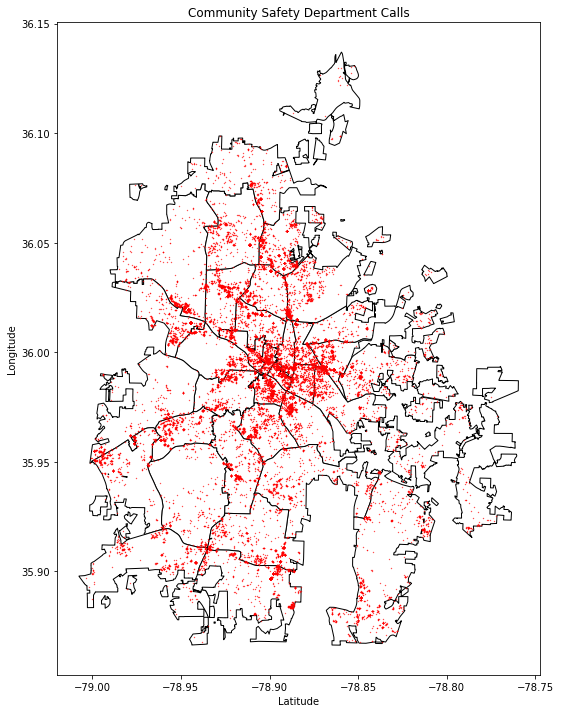

In [27]:
#Plot the two data sets together setting the aspect 'equal'
fig, ax = plt.subplots(figsize=(12, 12))

policebeats.plot(ax=ax, color='white', edgecolor='black')

dpdcalls.plot(ax=ax, marker='o', color='red', markersize=0.1)

ax.set(title='Community Safety Department Calls')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [28]:
#Filter calls and police beats for just community safety beats
commsafe_beats = policebeats.loc[policebeats['LAWBEAT'].isin(commsafe_list)].copy()

commsafe_calls = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()

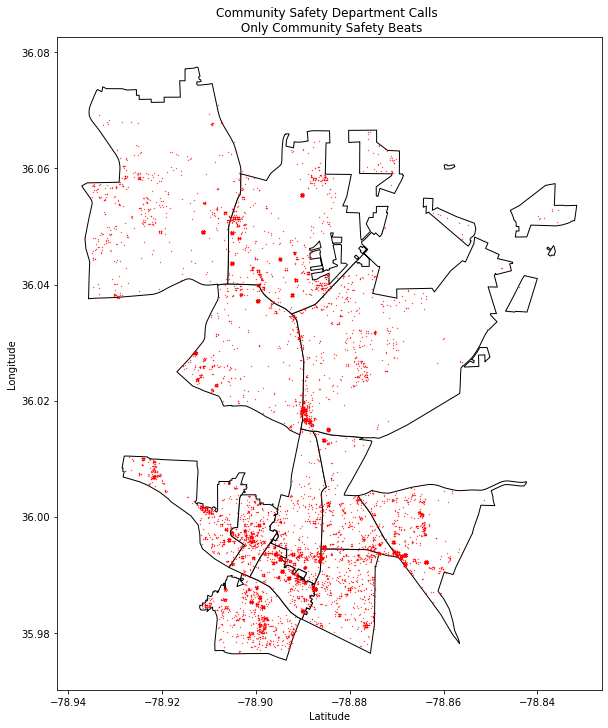

In [29]:
#Plot the two data sets together setting the aspect 'equal'
fig, ax = plt.subplots(figsize=(12, 12))

commsafe_beats.plot(ax=ax, color='white', edgecolor='black')

commsafe_calls.plot(ax=ax, marker='o', color='red', markersize=0.1)

ax.set(title='Community Safety Department Calls \n Only Community Safety Beats')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

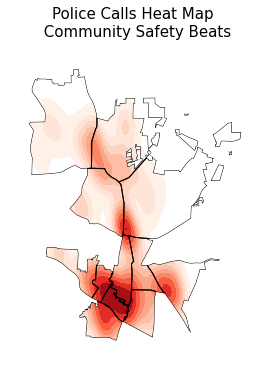

In [30]:
#Heat map of calls
ax = gplt.kdeplot(
    commsafe_calls, clip=commsafe_beats.geometry,
    shade=True, cmap='Reds',
    projection=gplt.crs.AlbersEqualArea())
gplt.polyplot(commsafe_beats, ax=ax, zorder=1, edgecolor='Black')

plt.title("Police Calls Heat Map \n Community Safety Beats", fontsize = 15)
plt.show()

In [31]:
#Merge policebats data with call data using polygon geometry
policebeats_w_dpd = gpd.sjoin(policebeats, dpdcalls)
policebeats_w_dpd.info

<bound method DataFrame.info of     LAWBEAT                                           geometry  OBJECTID  \
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
..      ...                                                ...       ...   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   

       PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_Dat

In [32]:
#Grouping dpdcalls by beat
allcalls = policebeats_w_dpd.groupby(['LAWBEAT']).size().to_frame(name = 'calls_count').reset_index()
allcalls.head()

LAWBEAT  calls_count
0      111          583
1      112          567
2      113          742
3      114          601
4      121          445

In [33]:
#Merge policebeats data with allcalls
callcount_beat = pd.merge(policebeats, allcalls, on ='LAWBEAT')
callcount_beat.head(3)

LAWBEAT                                           geometry  OBJECTID  \
0      111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1      112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
2      113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   

      PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_DataA1    ShapeSTAre  \
0  28608.800781      I        yes      D1  111       None  2.010252e+07   
1  26265.849609      I        yes      D1  112       None  2.079934e+07   
2  20667.539062      I        yes      D1  113       None  2.159195e+07   

     ShapeSTLen  LBeat  id  calls_count  
0  28608.799743    111   0          583  
1  26265.852604    112   1          567  
2  20667.538873    113   2          742

In [34]:
#Find the centroid of each polygon
callcount_beat['center'] = callcount_beat['geometry'].centroid
callcount_points = callcount_beat.copy()
callcount_points.set_geometry('center', inplace=True)

/var/folders/_r/3n990z1121zg5rjwb25b1tvm0000gn/T/ipykernel_67774/3888638873.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  callcount_beat['center'] = callcount_beat['geometry'].centroid


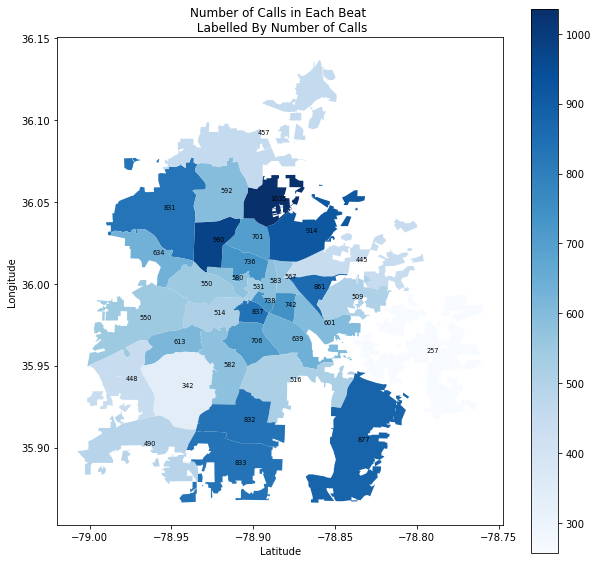

In [35]:
#Plot choropleth map of number of priority 2-6 calls with merged data
fig, ax = plt.subplots(figsize = (10,10))

callcount_beat.plot(column='calls_count',  
                         legend=True,  
                         cmap="Blues", ax=ax, aspect=1);

texts = []

for x, y, label in zip(callcount_points.geometry.x, callcount_points.geometry.y, callcount_points["calls_count"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

ax.set(title='Number of Calls in Each Beat \n Labelled By Number of Calls')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [36]:
#Filter for just community safety beats
callcount_beat_commsafe = callcount_beat.loc[callcount_beat['LAWBEAT'].isin(commsafe_list)]

#Find the centroid of each polygon
callcount_beat_commsafe['center'] = callcount_beat_commsafe['geometry'].centroid
callcount_commsafe_points = callcount_beat_commsafe.copy()
callcount_commsafe_points.set_geometry('center', inplace=True)

/var/folders/_r/3n990z1121zg5rjwb25b1tvm0000gn/T/ipykernel_67774/1848316111.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  callcount_beat_commsafe['center'] = callcount_beat_commsafe['geometry'].centroid
/Users/sadiesheridan/opt/miniconda3/envs/sadie/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


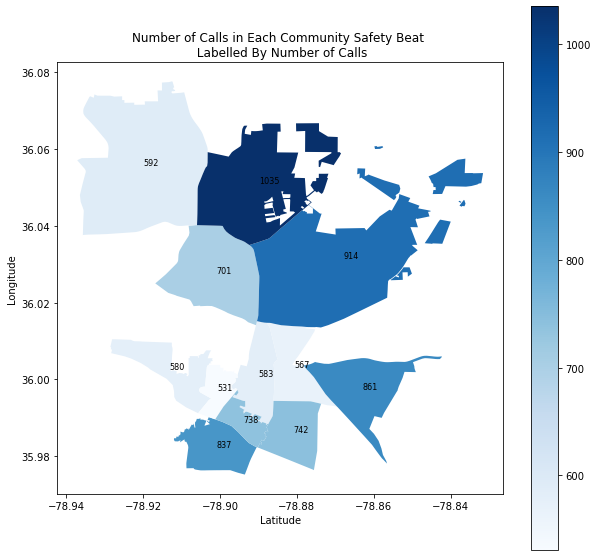

In [37]:
#Plot choropleth map of number of priority 2-6 calls with merged data
fig, ax = plt.subplots(figsize = (10,10))

callcount_beat_commsafe.plot(column='calls_count',  
                         legend=True,  
                         cmap="Blues", ax=ax, aspect=1);

texts = []

for x, y, label in zip(callcount_commsafe_points.geometry.x, callcount_commsafe_points.geometry.y, callcount_commsafe_points["calls_count"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

ax.set(title='Number of Calls in Each Community Safety Beat \n Labelled By Number of Calls')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [38]:
#Read in census data for North Carolina 2020 census blocks
ncblockmap = gpd.read_file('/Users/sadiesheridan/Desktop/tl_2021_37_tabblock20/tl_2021_37_tabblock20.shp')

#Set the crs for the census data
ncblockmap = ncblockmap.to_crs("EPSG:4326")

#Filter the block map to only include Durham blocks (63)
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

In [39]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockmap.index:
    cblock_geom = durhamblockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats = ncblockmap[ncblockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats['Beat'] = cblockDurhamBeats.index.map(lambda ii: cblockIndexToBeat[ii])

warnings.filterwarnings('ignore')

/var/folders/_r/3n990z1121zg5rjwb25b1tvm0000gn/T/ipykernel_67774/2285071337.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersectingAreas = possibleMatches.intersection(cblock_geom).area
/var/folders/_r/3n990z1121zg5rjwb25b1tvm0000gn/T/ipykernel_67774/2285071337.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersectingAreas = possibleMatches.intersection(cblock_geom).area
/var/folders/_r/3n990z1121zg5rjwb25b1tvm0000gn/T/ipykernel_67774/2285071337.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  intersectingAreas = possibleMatches.intersection(cblock_geom).area
/

In [40]:
#Load in 2020 race data from census bureau
racedata = pd.read_csv('/Users/sadiesheridan/Downloads/Race data/DECENNIALPL2020.P1_data_with_overlays_2022-06-06T132656.csv', skiprows = 1)

#Change id variable to GEOID20
racedata['GEOID20'] = racedata['id'].str[-15:]
racedata.drop('id', axis=1, inplace=True)

#Merging race data into the police beat and block data
raceineachbeat = pd.merge(racedata, cblockDurhamBeats)

#Grouping the population by police beat
raceineachbeat = raceineachbeat.groupby('Beat', as_index=False).sum()

#Adding beat geometry to popsumbybeat
raceineachbeat = pd.merge(policebeats, raceineachbeat, left_on='LAWBEAT', right_on='Beat')

#Change the column names for raceineachbeat
raceineachbeat.columns = raceineachbeat.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
raceineachbeat.columns = raceineachbeat.columns.str.replace('[#,@,&,!]', '')
raceineachbeat.columns = raceineachbeat.columns.str.replace('[:]', '_')
warnings.filterwarnings('ignore')

#Adding new columns to race in police beat data set
raceineachbeat['area'] = raceineachbeat.area
raceineachbeat['popdensity']= raceineachbeat['total_'] / raceineachbeat['area']
raceineachbeat['propwhite']= raceineachbeat['total_population_of_one_race_white_alone'] / raceineachbeat['total_']
raceineachbeat['propblack']= raceineachbeat['total_population_of_one_race_black_or_african_american_alone'] / raceineachbeat['total_']
raceineachbeat['propnativeamerican']= raceineachbeat['total_population_of_one_race_american_indian_and_alaska_native_alone'] / raceineachbeat['total_']
raceineachbeat['propasian']= raceineachbeat['total_population_of_one_race_asian_alone'] / raceineachbeat['total_']
raceineachbeat['proppacislander']= raceineachbeat['total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone'] / raceineachbeat['total_']
raceineachbeat['other']= raceineachbeat['total_'] - raceineachbeat['total_population_of_one_race_']
raceineachbeat['propother']= raceineachbeat['other'] / raceineachbeat['total_']
raceineachbeat.head()

lawbeat                                           geometry  objectid  \
0      111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1      112  POLYGON ((-78.88787 36.01473, -78.88734 36.014...        51   
2      113  POLYGON ((-78.87372 35.99369, -78.87458 35.991...        62   
3      114  MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...        65   
4      121  MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...        38   

      perimeter status contiguous lawdist  cad gis_dataa1    shapestare  \
0  28608.800781      I        yes      D1  111       None  2.010252e+07   
1  26265.849609      I        yes      D1  112       None  2.079934e+07   
2  20667.539062      I        yes      D1  113       None  2.159195e+07   
3  53321.980469      I        yes      D1  114       None  6.103382e+07   
4  14495.120117      I         no      D1  121       None  7.008533e+06   

     shapestlen  lbeat  id  beat  total_  total_population_of_one_race_  \
0  28608.799743    111   0   111    3949                           3539   
1  26265.852604    112   1   112    3083                           2860   
2  20667.538873    113   2   113    4094                           3876   
3  53321.974873    114   3   114    5631                           5214   
4  14495.120026    121   4   121    8025                           7501   

   total_population_of_one_race_white_alone  \
0                                      1242   
1                                       454   
2                                       891   
3                                       741   
4                                      1485   

   total_population_of_one_race_black_or_african_american_alone  \
0                                               1487              
1                                               1276              
2                                               2046              
3                                               2981              
4                                               4619              

   total_population_of_one_race_american_indian_and_alaska_native_alone  \
0                                                 91                      
1                                                 95                      
2                                                 66                      
3                                                 96                      
4                                                 88                      

   total_population_of_one_race_asian_alone  \
0                                        73   
1                                        18   
2                                        84   
3                                        61   
4                                        74   

   total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone  \
0                                                  3                               
1                                                  1                               
2                                                  1                               
3                                                  1                               
4                                                  4                               

   total_population_of_one_race_some_other_race_alone  \
0                                                643    
1                                               1016    
2                                                788    
3                                               1334    
4                                               1231    

   total_population_of_two_or_more_races_  \
0                                     410   
1                                     223   
2                                     218   
3                                     417   
4                                     524   

   total_population_of_two_or_more_races_population_of_two_races_  \
0                                         

In [41]:
#Find the centroid of each polygon
raceineachbeat['center'] = raceineachbeat['geometry'].centroid
raceineachbeat_points = raceineachbeat.copy()
raceineachbeat_points.set_geometry('center', inplace=True)

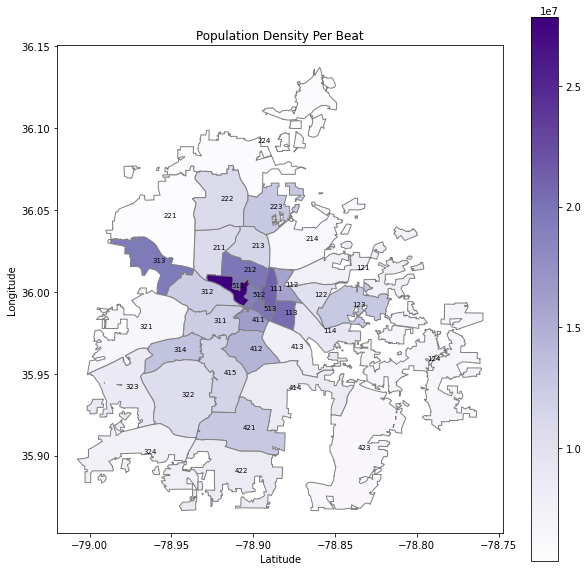

In [42]:
#Plot the population density data by beat
fig, ax = plt.subplots(figsize = (10,10))
raceineachbeat.plot(column='popdensity',
                                legend=True,
                                cmap="Purples", ax=ax, aspect=1, edgecolor='gray');

texts = []

for x, y, label in zip(raceineachbeat_points.geometry.x, raceineachbeat_points.geometry.y, raceineachbeat_points["lawbeat"]):
    texts.append(plt.text(x, y, label, fontsize = 7))

plt.title("Population Density Per Beat")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [43]:
#Print the five beats with the highest population density
population_density = raceineachbeat[['lawbeat', 'popdensity']]
population_density.sort_values(by='popdensity', inplace=True, ascending=False)
population_density.head(10)

lawbeat    popdensity
32      511  2.783313e+07
0       111  2.115229e+07
2       113  2.041984e+07
34      513  1.981489e+07
9       212  1.977689e+07
18      313  1.955184e+07
33      512  1.904815e+07
24      411  1.640552e+07
1       112  1.595999e+07
25      412  1.447698e+07

In [44]:
#Filter raceineachbeat for community safety beats
raceineachbeat_commsafe = raceineachbeat.loc[raceineachbeat['lawbeat'].isin(commsafe_list)]

#Find the centroid of each polygon
raceineachbeat_commsafe['center'] = raceineachbeat_commsafe['geometry'].centroid
raceineachbeat_commsafe_points = raceineachbeat_commsafe.copy()
raceineachbeat_commsafe_points.set_geometry('center', inplace=True)

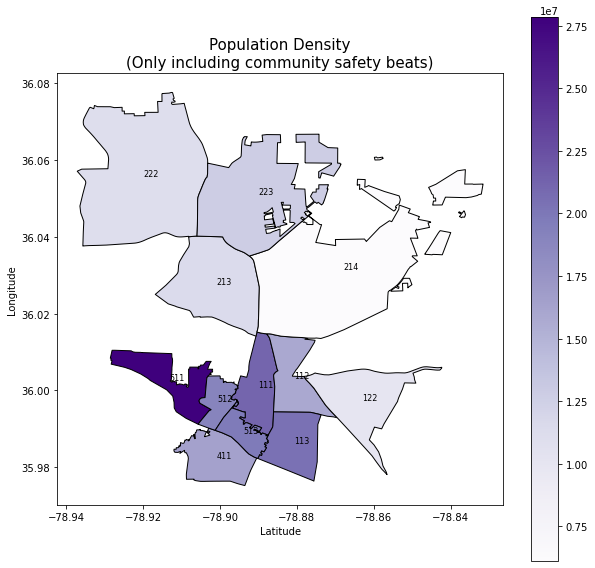

In [45]:
#Plot the population density by beat for com safe beats
fig, ax = plt.subplots(figsize = (10,10))
raceineachbeat_commsafe.plot(column='popdensity',
                                legend=True,
                                cmap="Purples", ax=ax, aspect=1, edgecolor='black');

texts = []

for x, y, label in zip(raceineachbeat_commsafe_points.geometry.x, raceineachbeat_commsafe_points.geometry.y, raceineachbeat_commsafe_points["lawbeat"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

plt.title("Population Density\n(Only including community safety beats)", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [46]:
#Merge comsafenatures with csdnature
comsafenatures_count = dpdcalls.set_index('Nature').join(csdnature_counts)
comsafenatures_count = comsafenatures_count.reset_index()

#Create call count table for community safety nature calls by beat
allnaturecalls = dpdcalls.groupby(['Beat']).size().to_frame(name = 'nature_calls_count').reset_index()
allnaturecalls['Beat'] = allnaturecalls['Beat'].astype(str)

#Create call count table for trespass cases
tres = comsafenatures_count.loc[comsafenatures_count['Nature']=='TRESPASS OR UNWANTED']
tres_naturecalls = tres.groupby(['Beat']).size().to_frame(name = 'Trespass Call Count').reset_index()
tres_naturecalls['Beat'] = tres_naturecalls['Beat'].astype(str)

#Create call count table for welfare cases
wel = comsafenatures_count.loc[comsafenatures_count['Nature']=='WELFARE CHECK']
wel_naturecalls = wel.groupby(['Beat']).size().to_frame(name = 'Welfare Check Call Count').reset_index()
wel_naturecalls['Beat'] = wel_naturecalls['Beat'].astype(str)

#Create call count table for intoxication cases
int = comsafenatures_count.loc[comsafenatures_count['Nature']=='INTOXICATED PERSON']
int_naturecalls = int.groupby(['Beat']).size().to_frame(name = 'Intoxicated Person Call Count').reset_index()
int_naturecalls['Beat'] = int_naturecalls['Beat'].astype(str)

#Create call count table for panhandling cases
pan = comsafenatures_count.loc[comsafenatures_count['Nature']=='PANHANDLING OR NUISANCE']
pan_naturecalls = pan.groupby(['Beat']).size().to_frame(name = 'Panhandling Call Count').reset_index()
pan_naturecalls['Beat'] = pan_naturecalls['Beat'].astype(str)

#Create call count table for suicide cases
sui = comsafenatures_count.loc[comsafenatures_count['Nature']=='SUICIDE THREAT']
sui_naturecalls = sui.groupby(['Beat']).size().to_frame(name = 'Suicide Threat Call Count').reset_index()
sui_naturecalls['Beat'] = sui_naturecalls['Beat'].astype(str)

#Create call count table for crisis cases
cri = comsafenatures_count.loc[comsafenatures_count['Nature']=='CRISIS']
cri_naturecalls = cri.groupby(['Beat']).size().to_frame(name = 'Crisis Call Count').reset_index()
cri_naturecalls['Beat'] = cri_naturecalls['Beat'].astype(str)

#Create call count table for urgent welfare cases
urgwel = comsafenatures_count.loc[comsafenatures_count['Nature']=='URGENT WELFARE CHECK']
urgwel_naturecalls = urgwel.groupby(['Beat']).size().to_frame(name = 'Urgent Welfare Check Call Count').reset_index()
urgwel_naturecalls['Beat'] = urgwel_naturecalls['Beat'].astype(str)

#Create call count table for assist person cases
assist = comsafenatures_count.loc[comsafenatures_count['Nature']=='ASSIST PERSON']
assist_naturecalls = assist.groupby(['Beat']).size().to_frame(name = 'Assist Person Call Count').reset_index()
assist_naturecalls['Beat'] = assist_naturecalls['Beat'].astype(str)

In [48]:
#Merge raceineachbeat with call data
calls_per_person = gpd.sjoin(raceineachbeat, dpdcalls)

In [49]:
#Change lawbeat to string
calls_per_person['lawbeat'] = calls_per_person['lawbeat'].astype(str)

#Join call type counts and add proportion columns
calls_per_person = calls_per_person.set_index('lawbeat').join(allnaturecalls.set_index('Beat'))
calls_per_person['nature_callsperperson']= calls_per_person['nature_calls_count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(sui_naturecalls.set_index('Beat')).copy()
calls_per_person['suicide_callsperperson']= calls_per_person['Suicide Threat Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(wel_naturecalls.set_index('Beat')).copy()
calls_per_person['welfare_callsperperson']= calls_per_person['Welfare Check Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(tres_naturecalls.set_index('Beat')).copy()
calls_per_person['trespass_callsperperson']= calls_per_person['Trespass Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(int_naturecalls.set_index('Beat')).copy()
calls_per_person['intoxicated_callsperperson']= calls_per_person['Intoxicated Person Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(pan_naturecalls.set_index('Beat')).copy()
calls_per_person['panhandling_callsperperson']= calls_per_person['Panhandling Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(urgwel_naturecalls.set_index('Beat')).copy()
calls_per_person['urgent_callsperperson']= calls_per_person['Urgent Welfare Check Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(assist_naturecalls.set_index('Beat')).copy()
calls_per_person['assist_callsperperson']= calls_per_person['Assist Person Call Count'] / calls_per_person['total_']

calls_per_person = calls_per_person.join(cri_naturecalls.set_index('Beat')).copy()
calls_per_person['crisis_callsperperson']= calls_per_person['Crisis Call Count'] / calls_per_person['total_']

calls_per_person=calls_per_person.reset_index()

calls_per_person.head()

index                                           geometry  objectid  \
0   111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
1   111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
2   111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
3   111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
4   111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   

      perimeter status contiguous lawdist  cad gis_dataa1    shapestare  \
0  28608.800781      I        yes      D1  111       None  2.010252e+07   
1  28608.800781      I        yes      D1  111       None  2.010252e+07   
2  28608.800781      I        yes      D1  111       None  2.010252e+07   
3  28608.800781      I        yes      D1  111       None  2.010252e+07   
4  28608.800781      I        yes      D1  111       None  2.010252e+07   

     shapestlen  lbeat  id  beat  total_  total_population_of_one_race_  \
0  28608.799743    111   0   111    3949                           3539   
1  28608.799743    111   0   111    3949                           3539   
2  28608.799743    111   0   111    3949                           3539   
3  28608.799743    111   0   111    3949                           3539   
4  28608.799743    111   0   111    3949                           3539   

   total_population_of_one_race_white_alone  \
0                                      1242   
1                                      1242   
2                                      1242   
3                                      1242   
4                                      1242   

   total_population_of_one_race_black_or_african_american_alone  \
0                                               1487              
1                                               1487              
2                                               1487              
3                                               1487              
4                                               1487              

   total_population_of_one_race_american_indian_and_alaska_native_alone  \
0                                                 91                      
1                                                 91                      
2                                                 91                      
3                                                 91                      
4                                                 91                      

   total_population_of_one_race_asian_alone  \
0                                        73   
1                                        73   
2                                        73   
3                                        73   
4                                        73   

   total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone  \
0                                                  3                               
1                                                  3                               
2                                                  3                               
3                                                  3                               
4                                                  3                               

   total_population_of_one_race_some_other_race_alone  \
0                                                643    
1                                                643    
2                                                643    
3                                                643    
4                                                643    

   total_population_of_two_or_more_races_  \
0                                     410   
1                                     410   
2                                     410   
3                                     410   
4                                     410   

   total_population_of_two_or_more_races_population_of_two_races_  \
0                                                384       

In [54]:
#Find centroid of policebeats geometry
policebeats["center"] = policebeats["geometry"].centroid
policebeats_points = policebeats.copy()
policebeats_points.set_geometry("center", inplace = True)
policebeats_points=policebeats_points.drop(columns=['geometry'])
policebeats_points=policebeats_points.rename(columns= {'center':'geometry'})

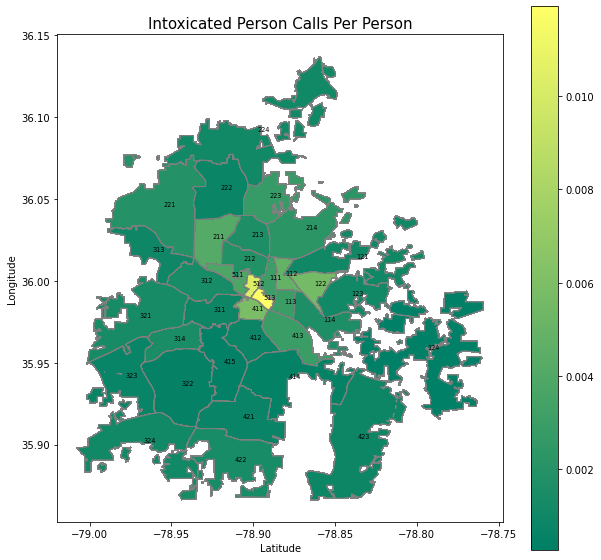

In [55]:
#Create choropleth of alcohol related nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='intoxicated_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");
texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5, color='black'))

plt.title("Intoxicated Person Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [56]:
#Print a table to show the alcohol proportions of each beat
nature_props = calls_per_person[['Beat', 'intoxicated_callsperperson', 'Intoxicated Person Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='intoxicated_callsperperson', inplace=True, ascending=False)
nature_props.head()

intoxicated_callsperperson  Intoxicated Person Call Count
Beat                                                           
513                     0.011300                      19.429119
512                     0.010213                      17.075330
411                     0.005821                      18.940263
122                     0.005521                      17.806565
112                     0.004846                      15.045608

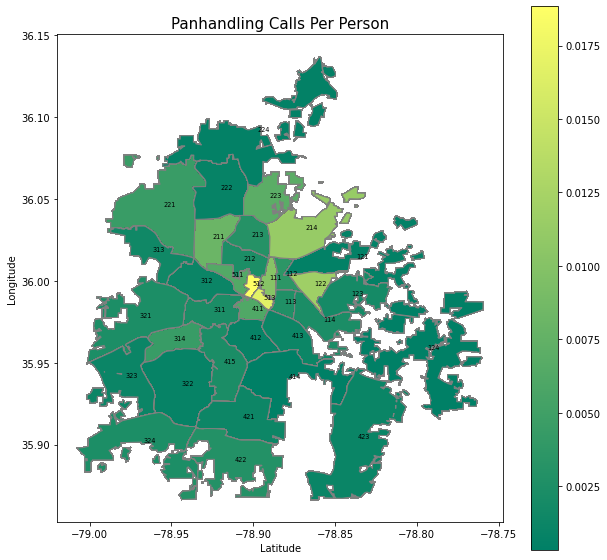

In [57]:
#Create choropleth of panhandling nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='panhandling_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Panhandling Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [58]:
#Print a table to show the panhandling proportions of each beat
pan_props = calls_per_person[['Beat', 'panhandling_callsperperson', 'Panhandling Call Count']]
pan_props = pan_props.groupby('Beat').mean()
pan_props.sort_values(by='panhandling_callsperperson', inplace=True, ascending=False)
pan_props.head()

panhandling_callsperperson  Panhandling Call Count
Beat                                                    
512                     0.018552               30.951036
513                     0.016086               28.180077
122                     0.011620               37.423212
214                     0.011195               74.281179
111                     0.009820               38.401060

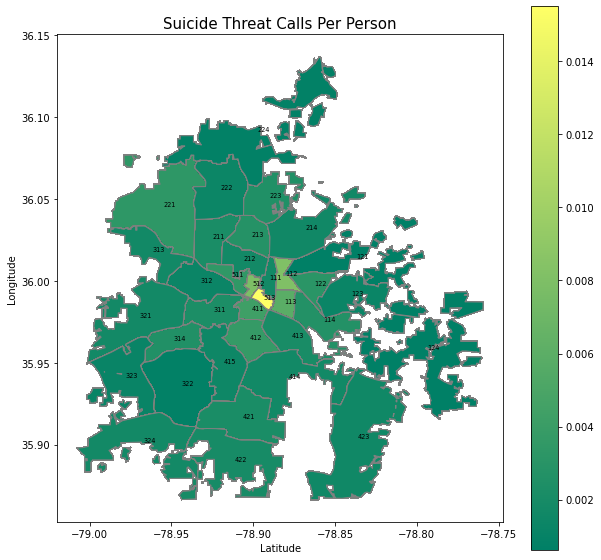

In [59]:
#Create choropleth of suicide nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='suicide_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Suicide Threat Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [61]:
#Print a table to show the suicide proportions of each beat
sui_props = calls_per_person[['Beat', 'suicide_callsperperson', 'Suicide Threat Call Count']]
sui_props = sui_props.groupby('Beat').mean()
sui_props.sort_values(by='suicide_callsperperson', inplace=True, ascending=False)
sui_props.head()

suicide_callsperperson  Suicide Threat Call Count
Beat                                                   
513                 0.014602                  24.997446
512                 0.007891                  13.231638
112                 0.007782                  24.109797
113                 0.005831                  23.813124
411                 0.004296                  13.998805

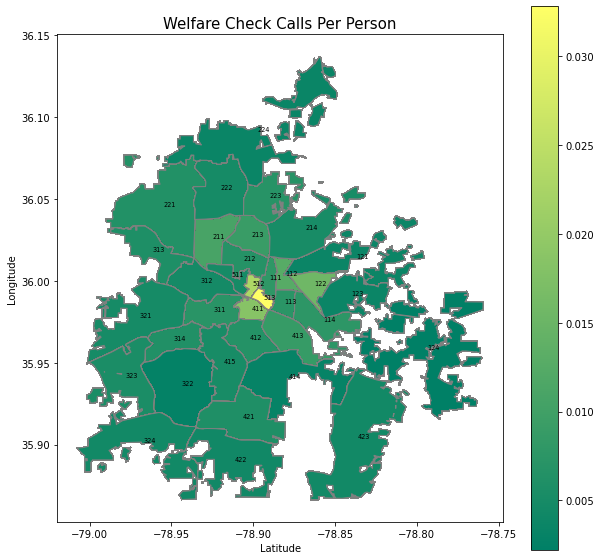

In [62]:
#Create choropleth of welfare nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='welfare_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Welfare Check Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [64]:
#Print a table to show the welfare proportions of each beat
nature_props = calls_per_person[['Beat', 'welfare_callsperperson', 'Welfare Check Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='welfare_callsperperson', inplace=True, ascending=False)
nature_props.head()

welfare_callsperperson  Welfare Check Call Count
Beat                                                  
513                 0.031002                 53.213282
512                 0.022864                 38.131827
411                 0.018364                 59.863799
122                 0.015392                 49.787808
112                 0.012637                 39.234797

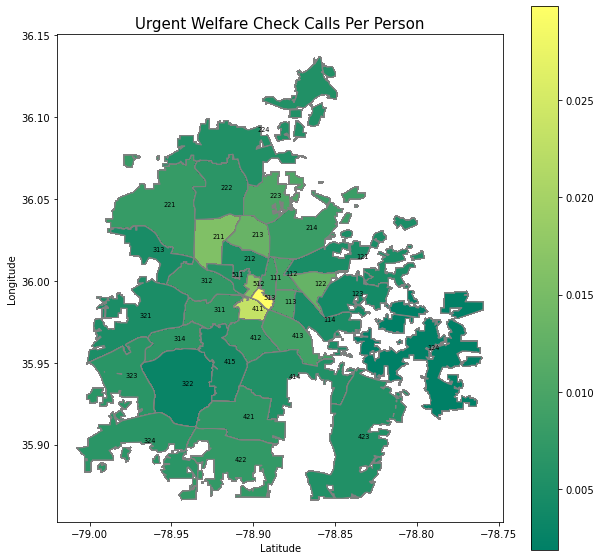

In [65]:
#Create choropleth of urgent welfare nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='urgent_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Urgent Welfare Check Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [66]:
#Print a table to show the urgent welfare proportions of each beat
nature_props = calls_per_person[['Beat', 'urgent_callsperperson', 'Urgent Welfare Check Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='urgent_callsperperson', inplace=True, ascending=False)
nature_props.head()

urgent_callsperperson  Urgent Welfare Check Call Count
Beat                                                        
513                0.028317                        48.979566
411                0.023208                        75.707288
512                0.016360                        27.453861
211                0.015697                       102.855556
213                0.013001                        66.014726

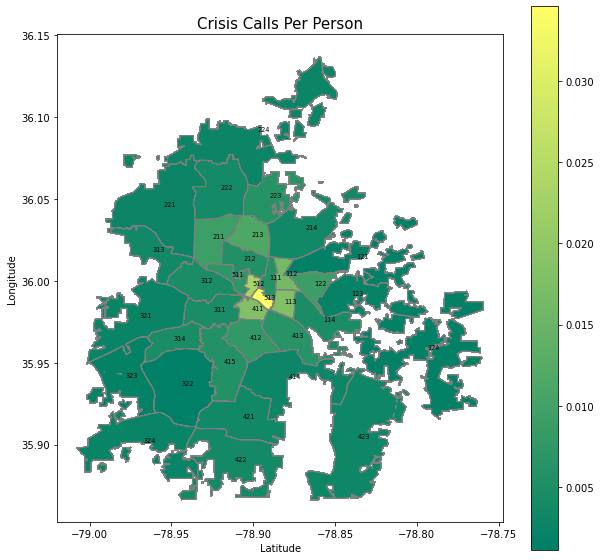

In [67]:
#Create choropleth of crisis nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='crisis_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Crisis Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [68]:
#Print a table to show the urgent welfare proportions of each beat
nature_props = calls_per_person[['Beat', 'crisis_callsperperson', 'Crisis Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='crisis_callsperperson', inplace=True, ascending=False)
nature_props.head()

crisis_callsperperson  Crisis Call Count
Beat                                          
513                0.032822          56.676884
512                0.022906          38.273070
411                0.018049          58.798088
113                0.017829          72.858773
112                0.015803          49.086149

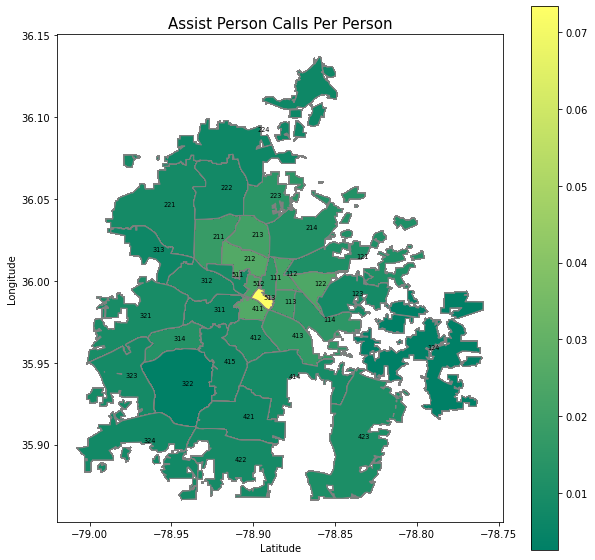

In [69]:
#Create choropleth of assist person nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='assist_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Assist Person Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [70]:
#Print a table to show the assist person proportions of each beat
nature_props = calls_per_person[['Beat', 'assist_callsperperson', 'Assist Person Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='assist_callsperperson', inplace=True, ascending=False)
nature_props.head()

assist_callsperperson  Assist Person Call Count
Beat                                                 
513                0.069138                118.664112
411                0.025676                 83.739546
212                0.025553                200.683333
122                0.024089                 78.121923
512                0.023484                 40.050847

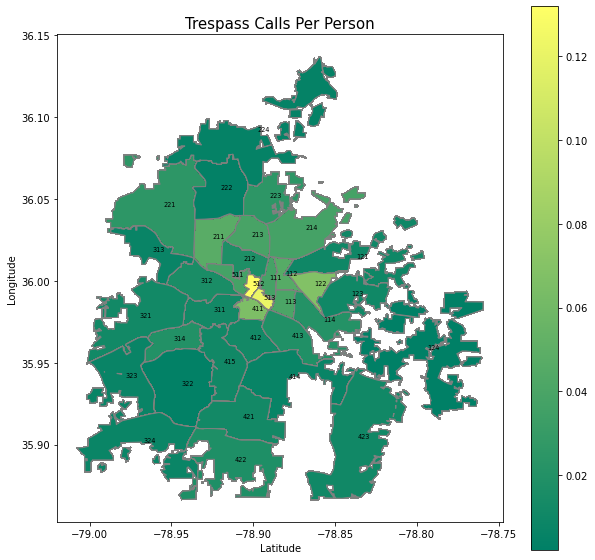

In [71]:
#Create choropleth of trespass calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='trespass_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Trespass Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [72]:
#Print a table to show the assist person proportions of each beat
nature_props = calls_per_person[['Beat', 'trespass_callsperperson', 'Trespass Call Count']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='trespass_callsperperson', inplace=True, ascending=False)
nature_props.head()

trespass_callsperperson  Trespass Call Count
Beat                                              
512                  0.129827           216.254237
513                  0.115965           200.588761
122                  0.067153           216.572098
411                  0.065917           214.384707
211                  0.046808           306.372727

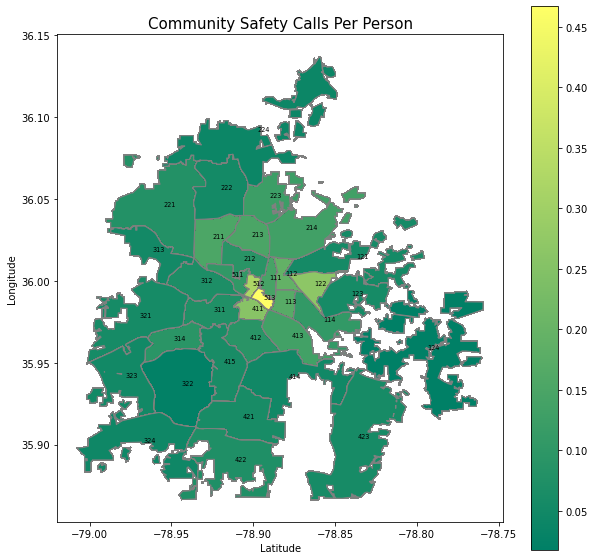

In [81]:
#Create choropleth of nature calls per person
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person.plot(column='nature_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="gray");

texts = []

for x, y, label in zip(policebeats_points.geometry.x, policebeats_points.geometry.y, policebeats_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Community Safety Calls Per Person", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [75]:
#Print a table to show the community safety nature calls per person of each beat
nature_props = calls_per_person[['Beat', 'nature_callsperperson']]
nature_props = nature_props.groupby('Beat').mean()
nature_props.sort_values(by='nature_callsperperson', inplace=True, ascending=False)
nature_props.head()

nature_callsperperson
Beat                       
513                0.444309
512                0.320045
122                0.262090
411                0.256108
112                0.194198

In [93]:
#Filter calls_per_person for only community safety beats
calls_per_person_commsafe = calls_per_person.loc[calls_per_person['lbeat'].isin(commsafe_list)]

#Filter policebeats for only community safety beats
policebeats_commsafe = policebeats.loc[policebeats['LAWBEAT'].isin(commsafe_list)]

In [94]:
#Add centroid to policebeats_commsafe
policebeats_commsafe['rep'] = policebeats_commsafe['geometry'].representative_point()
policebeats_commsafe_points=policebeats_commsafe.copy()
policebeats_commsafe_points.set_geometry("rep", inplace = True)
policebeats_commsafe_points=policebeats_commsafe_points.drop(columns=['geometry'])
policebeats_commsafe_points=policebeats_commsafe_points.rename(columns= {'rep':'geometry'})

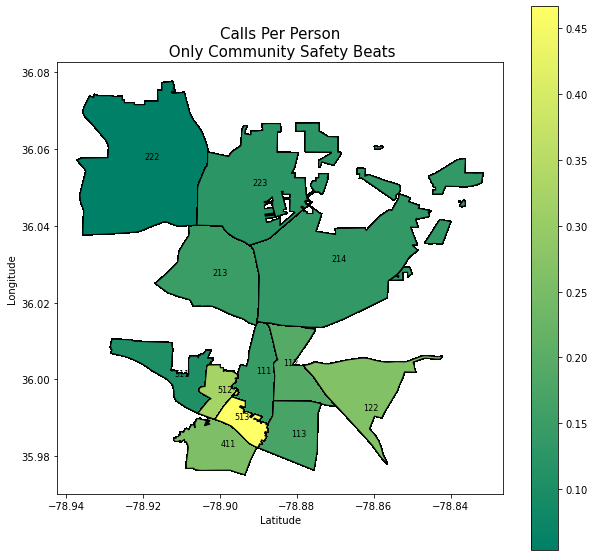

In [95]:
#Plot choropleth map for nature calls per person in community safety beats
fig, ax = plt.subplots(figsize = (10,10))
calls_per_person_commsafe.plot(column='nature_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax, aspect=1,
                                edgecolor="black");

texts = []

for x, y, label in zip(policebeats_commsafe_points.geometry.x, policebeats_commsafe_points.geometry.y, policebeats_commsafe_points["LAWBEAT"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
               
plt.title("Calls Per Person\n Only Community Safety Beats", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

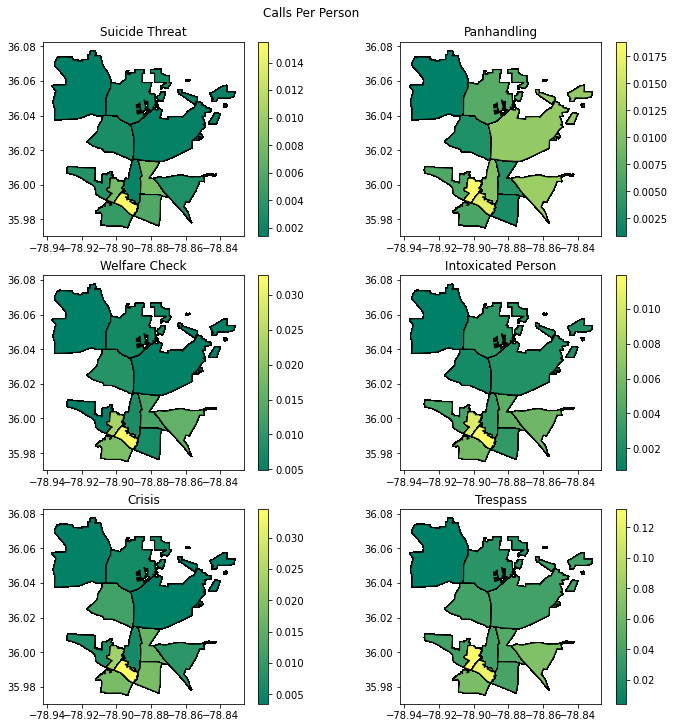

In [98]:
#Plot subplots of calls per person
fig = plt.figure(constrained_layout=True, figsize=(10, 10))

gridspan = fig.add_gridspec(1, 1)
gs = GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax1.title.set_text('Suicide Threat')
ax2.title.set_text('Panhandling')
ax3.title.set_text('Welfare Check')
ax4.title.set_text('Intoxicated Person')
ax5.title.set_text('Crisis')
ax6.title.set_text('Trespass')

# Set figure title
fig.suptitle("Calls Per Person")

#Plot subplots
calls_per_person_commsafe.plot(column='suicide_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax1, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='panhandling_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax2, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='welfare_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax3, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='intoxicated_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax4, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='crisis_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax5, aspect=1, edgecolor='black');

calls_per_person_commsafe.plot(column='trespass_callsperperson',
                                legend=True,
                                cmap="summer", ax=ax6, aspect=1, edgecolor='black');

plt.show()

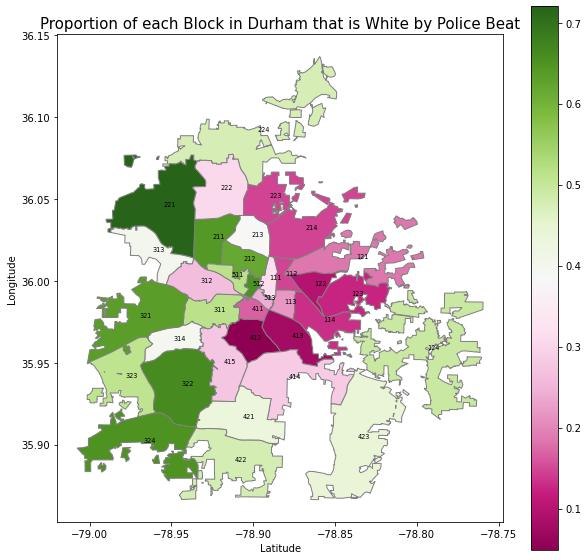

In [50]:
#Plot the race data by beat
fig, ax = plt.subplots(figsize = (10,10))
raceineachbeat.plot(column='propwhite',
                                legend=True,
                                cmap="PiYG", ax=ax, aspect=1, edgecolor='gray');

texts = []

for x, y, label in zip(raceineachbeat_points.geometry.x, raceineachbeat_points.geometry.y, raceineachbeat_points["lawbeat"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Proportion of each Block in Durham that is White by Police Beat", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [51]:
#Print the five beats with the highest proportion of white people
raceineachbeatprops = raceineachbeat[['lawbeat', 'propwhite']]
raceineachbeatprops.sort_values(by='propwhite', inplace=True, ascending=False)
raceineachbeatprops.head()

lawbeat  propwhite
12      221   0.720148
21      322   0.665034
33      512   0.653706
23      324   0.650155
8       211   0.643490

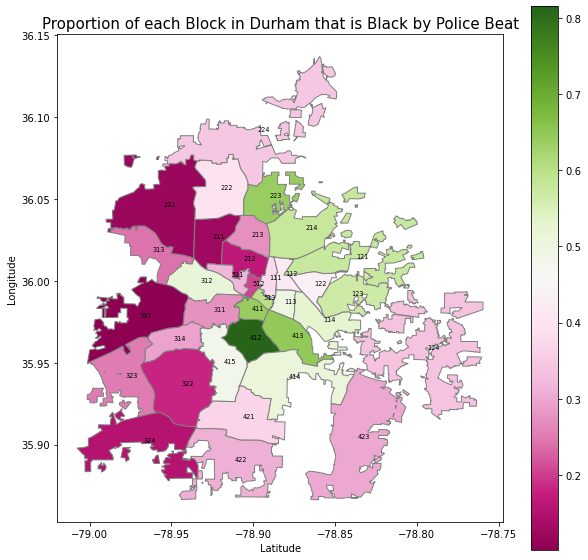

In [52]:
#Plot the race data by beat
fig, ax = plt.subplots(figsize = (10,10))
raceineachbeat.plot(column='propblack',
                                legend=True,
                                cmap="PiYG", ax=ax, aspect=1, edgecolor='gray');

texts = []

for x, y, label in zip(raceineachbeat_points.geometry.x, raceineachbeat_points.geometry.y, raceineachbeat_points["lawbeat"]):
    texts.append(plt.text(x, y, label, fontsize = 6.5))

plt.title("Proportion of each Block in Durham that is Black by Police Beat", fontsize = 15)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [53]:
#Print the five beats with the highest proportion of Black people
raceineachbeatprops = raceineachbeat[['lawbeat', 'propblack']]
raceineachbeatprops.sort_values(by='propblack', inplace=True, ascending=False)
raceineachbeatprops.head()

lawbeat  propblack
25      412   0.815303
26      413   0.647255
24      411   0.642134
14      223   0.638283
34      513   0.598092